**Train Test and Cross Validation**

In [7]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

data_path = '/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv'
df = pd.read_csv(data_path)

X = df.drop('Diabetes Status', axis=1)
y = df['Diabetes Status']

scaler = StandardScaler()
X = scaler.fit_transform(X)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [700],   
    'max_depth': [4],               
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X, y)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X)

print("Best Parameters for Random Forest:", grid_search.best_params_)
print("Mean Accuracy with Best Parameters:", grid_search.best_score_)

print("Random Forest Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for Random Forest: {'max_depth': 4, 'n_estimators': 700}
Mean Accuracy with Best Parameters: 0.6730595619103038
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1222
           1       0.69      0.74      0.71      1231

    accuracy                           0.70      2453
   macro avg       0.70      0.70      0.70      2453
weighted avg       0.70      0.70      0.70      2453

Confusion Matrix:
[[812 410]
 [322 909]]


**MAKE SURE TO RE RUN WITH MENTIONED RESULTS TO CHECK IF MODEL OVER FITS - USE EXAMPLES OF THE ABOVE STAGE**

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

valid_path = "/workspaces/Final-Year-Project/Cleaned Data/ValidationData.csv"

df_valid = pd.read_csv(valid_path)
df_valid = df_valid.dropna()

X_valid = df_valid.drop('Diabetes Status', axis=1)
y_valid = df_valid['Diabetes Status']

X_valid_scaled = scaler.transform(X_valid)

print(f"🧪 RF - Validation dataset shape: {X_valid.shape}")

y_pred_valid = best_rf.predict(X_valid_scaled)

print(f"📌 NN - Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid))

print("🟦 NN - Validation Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid))


🧪 RF - Validation dataset shape: (177, 10)
📌 NN - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        82
           1       0.74      0.86      0.80        95

    accuracy                           0.76       177
   macro avg       0.77      0.75      0.76       177
weighted avg       0.77      0.76      0.76       177

🟦 NN - Validation Confusion Matrix:
[[53 29]
 [13 82]]


Estimators doesnt seem to have change on val data

best is 4 or 5 depth - show less and more than

Final SHAP values shape: (177, 10)
X_valid shape: (177, 10)


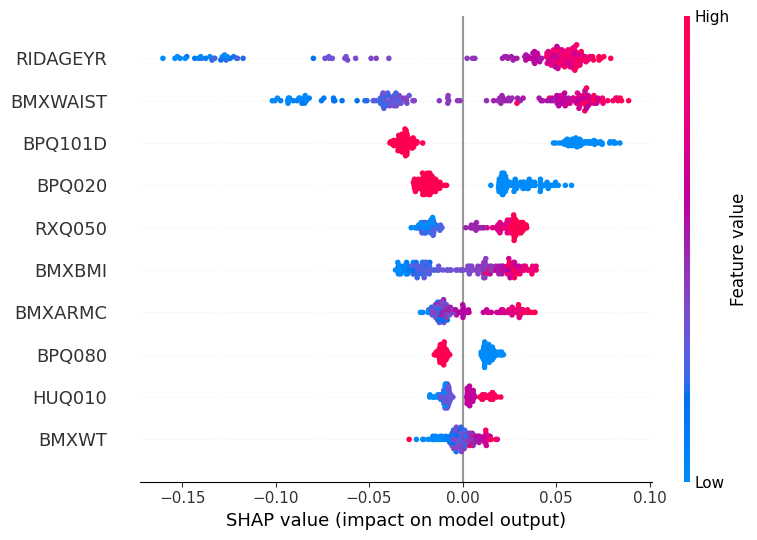

In [21]:
import shap

# Check if SHAP values need reshaping
print(f"Final SHAP values shape: {shap_values.shape}")
print(f"X_valid shape: {X_valid.shape}")

# If SHAP values shape is (177, 10), proceed as normal
if shap_values.shape == X_valid.shape:
    shap.summary_plot(shap_values, X_valid, feature_names=X_valid.columns, max_display=20)
else:
    print("⚠️ SHAP values shape does not match X_valid! Trying alternative fixes...")
    
    # If SHAP values have an extra dimension, try squeezing them
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # Extract values for class 1
        shap.summary_plot(shap_values, X_valid, feature_names=X_valid.columns, max_display=20)
    else:
        print("❌ Error: SHAP values still have mismatched shape! Debug needed.")



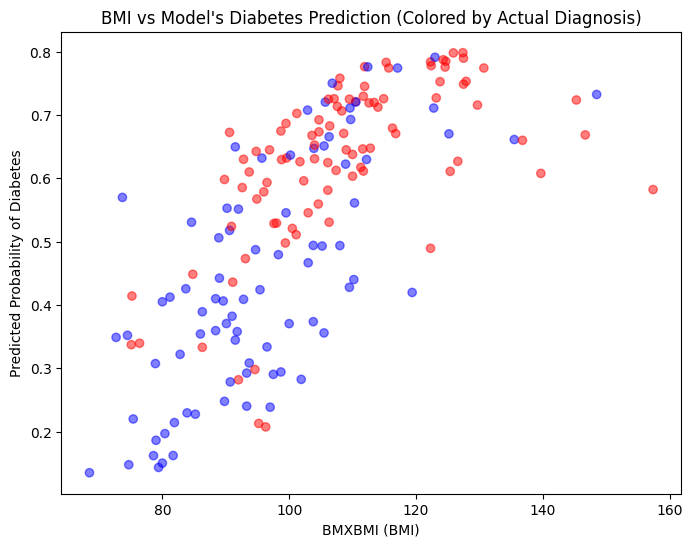

In [25]:
import matplotlib.pyplot as plt

# Get model's predicted probabilities for Diabetes (class 1)
diabetes_probs = best_rf.predict_proba(X_valid_scaled)[:, 1]

# Color the points based on actual diabetes status (y_valid)
colors = ["blue" if label == 0 else "red" for label in y_valid]

plt.figure(figsize=(8, 6))
plt.scatter(X_valid["BMXWAIST"], diabetes_probs, alpha=0.5, c=colors)
plt.xlabel("BMXBMI (BMI)")
plt.ylabel("Predicted Probability of Diabetes")
plt.title("BMI vs Model's Diabetes Prediction (Colored by Actual Diagnosis)")
plt.show()





In [31]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_valid_scaled,  # Use the scaled validation data
    feature_names=X_valid.columns,  # Keep original feature names
    class_names=["No Diabetes", "Diabetes"],  # Set class labels
    mode="classification"
)

# Select a sample index to explain
i = 54  # Pick a specific instance
print(f"Explaining prediction for sample {i}")

# Get the actual ground truth label
actual_label = y_valid.iloc[i]  # Fetch true label from validation dataset

# Predict model output for this instance
predicted_probs = best_rf.predict_proba(X_valid_scaled[i].reshape(1, -1))  # Get predicted probabilities
predicted_class = np.argmax(predicted_probs)  # Convert probabilities to class (0 or 1)

# Print ground truth vs predicted
print(f"Actual Diabetes Status: {actual_label} (0 = No Diabetes, 1 = Diabetes)")
print(f"Model Predicted Class: {predicted_class} (Probability: {predicted_probs[0][predicted_class]:.2f})")

# Explain the instance with LIME
exp = explainer.explain_instance(
    X_valid_scaled[i],  # The instance to explain
    best_rf.predict_proba,  # The model's probability prediction function
    num_features=10  # Show top 10 most important features
)

# Display explanation in the notebook
exp.show_in_notebook()



Explaining prediction for sample 54
Actual Diabetes Status: 0 (0 = No Diabetes, 1 = Diabetes)
Model Predicted Class: 0 (Probability: 0.58)
